# Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn

from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Model, Sequential
from keras import layers
from keras.optimizers import Adam
from keras.regularizers import L1, L2, Regularizer, L1L2
from keras import ops
from keras.callbacks import ReduceLROnPlateau
import keras

import imblearn

from time import perf_counter

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\thead\AppData\Local\Temp\ipykernel_25144\1803658105.py:3: DtypeWarning: Columns (2155) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [3]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [4]:
trait_cols = np.array(['Photo',
       'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo',
       'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C',
       'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a',
       'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch',
       'Ellagic', 'Gal', 'Rut', 'CTs'])

In [5]:
x_spec = df[spec_cols].values
yb = df[stresses].values.any(axis=1)

In [6]:
x_t = df['Time'].values.reshape((-1,1))

## Helper Functions

In [7]:
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

In [8]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

# Preprocess

In [9]:
x_spec = ((x_spec - x_spec.min(axis=0))/(x_spec.max(axis=0)-x_spec.min(axis=0)))

val_sel = np.random.random(size=(x_spec.shape[0],)) < .2
x_spec_train, x_t_train, yb_train = x_spec[~val_sel], x_t[~val_sel], yb[~val_sel]
x_spec_val, x_t_val, yb_val = x_spec[val_sel], x_t[val_sel], yb[val_sel]

#### Oversample Minority Class

In [10]:
# sampler = imblearn.over_sampling.RandomOverSampler()
# x_temp, yb_train = sampler.fit_resample(np.hstack((x_spec_train, x_t_train)), yb_train)
# x_spec_train, x_t_train = x_temp[:,:-1], x_temp[:,-1].reshape((-1,1))

## Resblock

In [11]:
def ResBlock1D(x, kernel_size=3, k_reg=.001, pool=3, n_filters=10):
    # padding has to be 'same' for add to work
    
    fx = layers.Conv1D(n_filters, kernel_size, activation='relu', padding='same', kernel_regularizer=L2(k_reg))(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv1D(n_filters, kernel_size, activation='relu', padding='same', kernel_regularizer=L2(k_reg))(fx)

    ix = layers.Conv1D(n_filters, 1, activation='relu', padding='same', kernel_regularizer=L2(k_reg))(x)
    out = layers.Add()([ix, fx])
    out = layers.LeakyReLU()(out)
    out = layers.BatchNormalization()(out)
    out = layers.MaxPooling1D(pool)(out)
    return out

## Autoencoder

In [12]:
k_reg = 0
l_reg = 0
ae_layers = []

ae_layers.append(layers.Cropping1D(cropping=(0, x_spec.shape[-1]-2048)))

for _ in range(3):
    ae_layers.append(layers.Conv1D(32, 4, activation='relu', padding='same', kernel_regularizer=L2(k_reg)))
    ae_layers.append(layers.MaxPooling1D(4))

# ae_layers.append(layers.Flatten())
# ae_layers.append(layers.Dense(64, activation='relu', kernel_regularizer=L2(l_reg)))

# ae_layers.append(layers.Reshape((64, 1)))

for _ in range(3):
    ae_layers.append(layers.Conv1D(32, 4, activation='relu', padding='same', kernel_regularizer=L2(k_reg)))
    ae_layers.append(layers.UpSampling1D(4))

ae_layers.append(layers.Conv1D(1, 4, activation='relu', padding='same', kernel_regularizer=L2(k_reg)))

# ae_layers.append(layers.Flatten())

# ae_layers.append(layers.Dense(x_spec.shape[-1], activation='relu', kernel_regularizer=L2(l_reg)))
# ae_layers.append(layers.Reshape((x_spec.shape[-1], 1)))

ae_layers.append(layers.ZeroPadding1D(padding=(0,x_spec.shape[-1]-2048)))

fx = layers.Input(shape=(x_spec.shape[1],1))
for i, layer in enumerate(ae_layers):
    fx = layer(fx)
    print(f'{i} {fx}')

ae_model = Sequential(ae_layers)
ae_model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mse'])


0 <KerasTensor shape=(None, 2048, 1), dtype=float32, sparse=False, name=keras_tensor_1>
1 <KerasTensor shape=(None, 2048, 32), dtype=float32, sparse=False, name=keras_tensor_2>
2 <KerasTensor shape=(None, 512, 32), dtype=float32, sparse=False, name=keras_tensor_3>
3 <KerasTensor shape=(None, 512, 32), dtype=float32, sparse=False, name=keras_tensor_4>
4 <KerasTensor shape=(None, 128, 32), dtype=float32, sparse=False, name=keras_tensor_5>
5 <KerasTensor shape=(None, 128, 32), dtype=float32, sparse=False, name=keras_tensor_6>
6 <KerasTensor shape=(None, 32, 32), dtype=float32, sparse=False, name=keras_tensor_7>
7 <KerasTensor shape=(None, 32, 32), dtype=float32, sparse=False, name=keras_tensor_8>
8 <KerasTensor shape=(None, 128, 32), dtype=float32, sparse=False, name=keras_tensor_9>
9 <KerasTensor shape=(None, 128, 32), dtype=float32, sparse=False, name=keras_tensor_10>
10 <KerasTensor shape=(None, 512, 32), dtype=float32, sparse=False, name=keras_tensor_11>
11 <KerasTensor shape=(None, 5

In [13]:
history = ae_model.fit(
    cnn_reshape(x_spec_train),
    cnn_reshape(x_spec_train),
    epochs=150,
    validation_data=(cnn_reshape(x_spec_val), cnn_reshape(x_spec_val)),
    batch_size=200,
    # callbacks=[ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=1e-5)]
)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 0.2488 - mse: 0.2488 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.2483 - mse: 0.2483 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.2495 - mse: 0.2495 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.2465 - mse: 0.2465 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.2480 - mse: 0.2480 - val_loss: 0.2414 - val_mse: 0.2414
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.2495 - mse: 0.2495 - val_loss: 0.2359 - val_mse: 0.2359
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.2382 - mse: 0.2382 - val_loss: 0.2256 - val_mse: 0.2256
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.2308 - mse: 0.2308 - val_loss: 0.2157 - val_mse: 0.2157
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.2211 - m

In [14]:
x_ae_train = cnn_reshape(x_spec_train)
for layer in ae_model.layers[:8]:
    x_ae_train = layer(x_ae_train)
x_ae_train = x_ae_train.numpy()

x_ae_val = cnn_reshape(x_spec_val)
for layer in ae_model.layers[:8]:
    x_ae_val = layer(x_ae_val)
x_ae_val = x_ae_val.numpy()

In [15]:
x_ae_train.shape

(834, 32, 32)

# CNN

In [16]:
def make_model(x, t,
    fuzzy_win = 5, blur_factor = 5, spatial_dropout_k = 0.2, dropout_k = .05, l_reg = .001, c_reg = .001,
    n_filters=10, kernel_size=3, pool=5, n_conv_layers=3, n_conv_layers_pool_1=1, n_linear_layers=16, linear_size=50
):
    cnn_model_layers = [
        # layers.GaussianNoise(.0),
        # layers.Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
        # layers.AveragePooling1D(blur_factor),
    ]

    for _ in range(n_conv_layers):
        cnn_model_layers.append(lambda x: ResBlock1D(x, kernel_size=kernel_size, k_reg=c_reg, pool=pool, n_filters=n_filters))
        cnn_model_layers.append(layers.SpatialDropout1D(spatial_dropout_k))
    for _ in range(n_conv_layers_pool_1):
        cnn_model_layers.append(lambda x: ResBlock1D(x, kernel_size=kernel_size, k_reg=c_reg, pool=1, n_filters=n_filters))
        cnn_model_layers.append(layers.SpatialDropout1D(spatial_dropout_k))
    
    
    linear_layers = [
    ]
    
    # for _ in range(1):
    #     linear_layers.append(layers.Dense(128, activation='relu', kernel_regularizer=L2(l_reg)))
    #     linear_layers.append(layers.Dropout(dropout_k))
    
    for _ in range(n_linear_layers):
        linear_layers.append(layers.Dense(linear_size, activation='relu', kernel_regularizer=L2(l_reg)))
        linear_layers.append(layers.Dropout(dropout_k))

    for _ in range(n_linear_layers):
        linear_layers.append(layers.Dense(linear_size//2, activation='relu', kernel_regularizer=L2(l_reg)))
        linear_layers.append(layers.Dropout(dropout_k))
    
    linear_layers.append(layers.Dense(1, activation='sigmoid'))
    
    
    
    spec_inputs = layers.Input(shape=(x.shape[1],x.shape[2]))
    t_inputs = layers.Input(shape=(t.shape[1],))
    
    fx = spec_inputs
    
    for layer in cnn_model_layers:
        print(fx.shape)
        fx = layer(fx)
    
    fx = layers.Flatten()(fx)
    fx = layers.Concatenate()([fx, t_inputs])
    
    for layer in linear_layers:
        fx = layer(fx)
    
    cnn_model_outputs = fx
    cnn_model = Model(inputs=[spec_inputs, t_inputs], outputs=cnn_model_outputs)
    
    cnn_model.compile(optimizer=Adam(4e-4), loss='binary_crossentropy', metrics=['accuracy'])
    # cnn_model.compile(optimizer=Adam(1e-4), loss=keras.losses.BinaryFocalCrossentropy(alpha=.1), metrics=['accuracy'])

    return cnn_model

In [17]:
# acc = {'n_linear_layers': [], 'linear_size': [], 'accuracy': []}

# for n_linear_layers in [8, 16, 32]:
#     for linear_size in [32, 64, 128]:

#         cnn_model = make_model(n_linear_layers=n_linear_layers, linear_size=linear_size)

#         start = perf_counter()
        
#         history = cnn_model.fit(
#             [cnn_reshape(x_spec_train), x_t_train],
#             yb_train,
#             epochs=100,
#             validation_data=([cnn_reshape(x_spec_val), x_t_val], yb_val),
#             batch_size=5,
#             # callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=20, min_lr=1e-5)]
#         )

#         acc['n_linear_layers'].append(n_linear_layers)
#         acc['linear_size'].append(linear_size)

#         a = ((cnn_model.predict([cnn_reshape(x_spec_val), x_t_val]) > .5) == yb_val).mean()
#         acc['accuracy'].append(a)
        
#         print(f'n_linear_layers={n_linear_layers}, linear_size={linear_size}, acc={a}, time={perf_counter() - start}')

In [18]:
cnn_model = make_model(x_ae_train, x_t_train,
    n_linear_layers=8, linear_size=32, n_filters=8, spatial_dropout_k = 0.125, dropout_k = .00, kernel_size=3,
    n_conv_layers=1, n_conv_layers_pool_1=3, c_reg=0.000, l_reg=0.000, pool=2
)

start = perf_counter()

history = cnn_model.fit(
    [x_ae_train, x_t_train],
    yb_train,
    epochs=300,
    validation_data=([x_ae_val, x_t_val], yb_val),
    batch_size=1000,
    # callbacks=[ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=30, min_lr=1e-5)]
)

a = ((cnn_model.predict([x_ae_val, x_t_val]).flatten() > .5) == yb_val).mean()

print(f'acc={a}, time={perf_counter() - start}')

(None, 32, 32)
(None, 16, 8)
(None, 16, 8)
(None, 16, 8)
(None, 16, 8)
(None, 16, 8)
(None, 16, 8)
(None, 16, 8)
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3357 - loss: 0.6954 - val_accuracy: 0.6111 - val_loss: 0.6930
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3525 - loss: 0.6946 - val_accuracy: 0.6768 - val_loss: 0.6924
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5120 - loss: 0.6932 - val_accuracy: 0.6768 - val_loss: 0.6920
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6475 - loss: 0.6924 - val_accuracy: 0.6768 - val_loss: 0.6916
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6619 - loss: 0.6917 - val_accuracy: 0.6768 - val_loss: 0.6913
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6643 - loss: 0.6912 - val_accuracy: 0.6768 - val_loss: 0.6909
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6643 - loss: 0.6908 - val_accuracy: 0.6768 - val_loss: 0.6905
Epoch

In [19]:
yb_train.mean()

0.6642685851318945

In [20]:
((cnn_model.predict([x_ae_val, x_t_val]) > .5).flatten() == yb_val).mean(), (yb_val).mean()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(0.7828282828282829, 0.6767676767676768)

Text(0.5, 1.0, 'CNN Accuracy over Training')

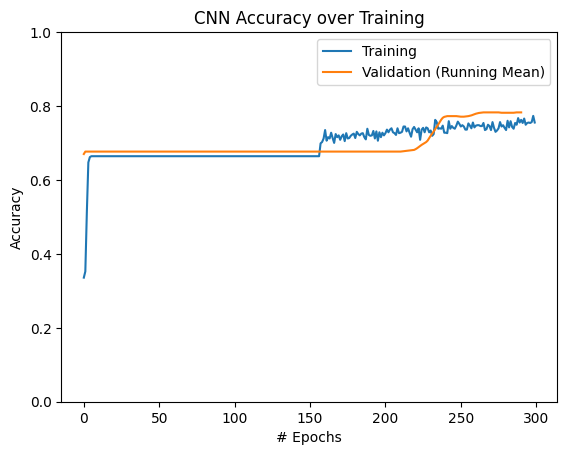

In [21]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('CNN Accuracy over Training')

In [22]:
y_pred = cnn_model.predict([x_ae_val, x_t_val])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [23]:
y_pred_i = (y_pred > .5).flatten()
tn = ((y_pred_i == 0) & (yb_val == 0)).mean()
fn = ((y_pred_i == 0) & (yb_val == 1)).mean()
tp = ((y_pred_i == 1) & (yb_val == 1)).mean()
fp = ((y_pred_i == 1) & (yb_val == 0)).mean()

tn, fn, tp, fp

(0.10606060606060606, 0.0, 0.6767676767676768, 0.21717171717171718)

In [24]:
tp / (tp + fp), tn/(tn + fp), fn/(tn+fn)

(0.7570621468926553, 0.328125, 0.0)

In [25]:
t_pred = np.vstack((x_t_val.flatten(), (y_pred.flatten()>.5) == yb_val)).T

In [26]:
for t in range(4):
    print(f'{t}: {t_pred[t_pred[:,0]==t][:,1].mean()}')

0: 1.0
1: 0.7444444444444445
2: 0.765625
3: 0.782608695652174


### Risky Model

In [113]:
risky_models = [make_model(x_ae_train, x_t_train,
    n_linear_layers=4, linear_size=16, n_filters=4, spatial_dropout_k = 0.00, dropout_k = .0, kernel_size=3,
    n_conv_layers=3, n_conv_layers_pool_1=0, c_reg=0.002, l_reg=0.002, pool=2
) for _ in range(4)]

start = perf_counter()

for i in range(len(risky_models)):
    history = risky_models[i].fit(
        [x_ae_train, x_t_train],
        yb_train,
        epochs=100,
        validation_data=([x_ae_val, x_t_val], yb_val),
        batch_size=10,
        class_weight={0: 4**(i+1), 1: 1}
        # callbacks=[ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=30, min_lr=1e-5)]
    )
    
    a = ((risky_models[i].predict([x_ae_val, x_t_val]).flatten() > .5) == yb_val).mean()

    y_pred = risky_models[i].predict([x_ae_val, x_t_val]).flatten()
    y_pred_i = (y_pred > .5).flatten()
    tn = ((y_pred_i == 0) & (yb_val == 0)).mean()
    fn = ((y_pred_i == 0) & (yb_val == 1)).mean()
    tp = ((y_pred_i == 1) & (yb_val == 1)).mean()
    fp = ((y_pred_i == 1) & (yb_val == 0)).mean()

    print(f'acc={a}, positive_rate={tp/(tp+fn)}, negative_rate={tn/(tn + fp)}, time={perf_counter() - start}')

(None, 32, 32)
(None, 16, 4)
(None, 16, 4)
(None, 8, 4)
(None, 8, 4)
(None, 4, 4)
(None, 32, 32)
(None, 16, 4)
(None, 16, 4)
(None, 8, 4)
(None, 8, 4)
(None, 4, 4)
(None, 32, 32)
(None, 16, 4)
(None, 16, 4)
(None, 8, 4)
(None, 8, 4)
(None, 4, 4)
(None, 32, 32)
(None, 16, 4)
(None, 16, 4)
(None, 8, 4)
(None, 8, 4)
(None, 4, 4)
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3487 - loss: 1.6592 - val_accuracy: 0.3232 - val_loss: 0.9727
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3607 - loss: 1.5472 - val_accuracy: 0.3232 - val_loss: 0.9657
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3301 - loss: 1.4492 - val_accuracy: 0.3232 - val_loss: 0.9544
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3490 - loss: 1.4114 - val_accuracy: 0.3232 - val_loss: 0.9149
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3443 - loss: 1.3769 - val_accuracy: 0.3232 - val_loss: 0.8897
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'Risky CNN loss over Training')

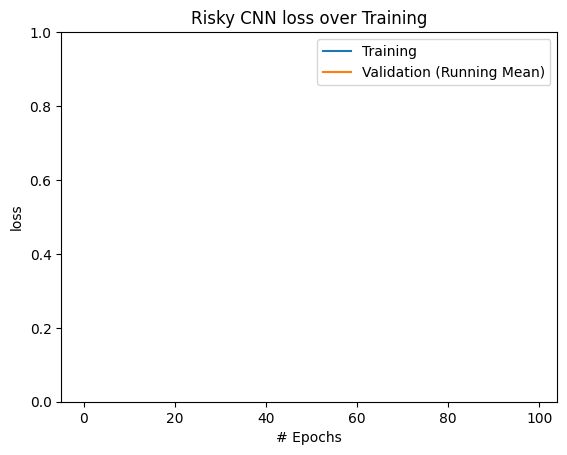

In [114]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('loss')
ax.set_ylim((0, 1))
ax.set_title('Risky CNN loss over Training')

In [115]:
y_pred = risky_models[-1].predict([x_ae_val, x_t_val]).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [116]:
y_pred_i = (y_pred > .5).flatten()
tn = ((y_pred_i == 0) & (yb_val == 0)).mean()
fn = ((y_pred_i == 0) & (yb_val == 1)).mean()
tp = ((y_pred_i == 1) & (yb_val == 1)).mean()
fp = ((y_pred_i == 1) & (yb_val == 0)).mean()

tn, fn, tp, fp

(0.32323232323232326, 0.6767676767676768, 0.0, 0.0)

In [117]:
tn/(tn + fp)

1.0

In [118]:
cnn_predict = cnn_model.predict([x_ae_val, x_t_val]).flatten()
risky_predict = risky_model.predict([x_ae_val, x_t_val]).flatten()

sel = (cnn_predict > .5) & (risky_predict < .5)

(np.vstack((
    cnn_predict,
    risky_predict,
    yb_val
)).T > .5)[sel].mean(axis=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([1.  , 0.  , 0.76])

In [119]:
top_model = sklearn.linear_model.LogisticRegression()
xm_train = np.hstack([cnn_model.predict([x_ae_train, x_t_train])] + [risky_models[i].predict([x_ae_train, x_t_train]) for i in range(len(risky_models))])
xm_val = np.hstack([cnn_model.predict([x_ae_val, x_t_val])] + [risky_models[i].predict([x_ae_val, x_t_val]) for i in range(len(risky_models))])

top_model.fit(xm_train, yb_train)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


LogisticRegression()

In [120]:
(top_model.predict(xm_val) == yb_val).mean()

0.7121212121212122

In [112]:
top_model.coef_

array([[0.85287882, 5.46718156, 0.68462707, 1.96821083, 1.69881954]])

# Individual Stresses

In [69]:
stress_sel = df[stresses].any(axis=1)
x_traits = df[stress_sel][trait_cols].values
yi = df[stress_sel][stresses].values
x_t_stress = x_t[stress_sel]

In [70]:
# Normalize

x_traits = ((x_traits - x_traits.min(axis=0))/(x_traits.max(axis=0)-x_traits.min(axis=0)))

In [71]:
# Keep only single stress samples

sel_1 = yi.sum(axis=1).flatten() == 1
x_traits = x_traits[sel_1]
yi = yi[sel_1]
x_t_stress = x_t_stress[sel_1]

In [72]:
(yi.sum(axis=1) > 1).mean()

0.0

#### Cancel Out

In [31]:
class COReg(Regularizer):
    def __init__(self, lambda_1=1e-3, lambda_2=1e-3):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2

    def call(self, x):
        return -1*lambda_1*ops.var(x) + L1(lambda_2)(x)

class CancelOutLayer(keras.layers.Layer):
    def __init__(self, lambda_1=1e-3, lambda_2=1e-3, **kwargs):
        super(CancelOutLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        weight_shape = (1, input_shape[-1])

        
        
        self.kernel = self.add_weight(
            name='kernel', 
            shape=weight_shape,
            initializer='uniform',
            trainable=True,
            regularizer=COReg
        )
        
        self.bias = self.add_weight(
            name='bias', 
            shape=weight_shape,
            initializer='zeros',
            trainable=True
        )
        
        self.built=True
    
    #operation:
    def call(self, inputs):
        return (inputs * self.kernel) + self.bias
    
    #output shape
    def compute_output_shape(self, input_shape):
        return input_shape
    
    #for saving the model - only necessary if you have parameters in __init__
    def get_config(self):
        config = super(SingleConnected, self).get_config()
        return config

### Train

In [73]:
val_sel = np.random.random(size=(x_traits.shape[0],)) < .2
x_traits_train, x_traits_val = x_traits[~val_sel], x_traits[val_sel]
yi_train, yi_val = yi[~val_sel], yi[val_sel]
x_t_stress_train, x_t_stress_val = x_t_stress[~val_sel], x_t_stress[val_sel]

#### NN

In [148]:
l_reg = 0

individual_layers = []

individual_layers.append(CancelOutLayer(lambda_1=0, lambda_2=0))

for _ in range(6):
    individual_layers.append(layers.Dense(32, activation='relu', kernel_regularizer=L2(l_reg)))
    # individual_layers.append(layers.BatchNormalization())
    individual_layers.append(layers.Dropout(0.00))

individual_layers.append(layers.Dense(yi.shape[1], activation='softmax'))

individual_model = Sequential(individual_layers)

individual_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = perf_counter()

history = individual_model.fit(
    np.hstack((x_traits_train, x_t_stress_train)),
    yi_train,
    epochs=600,
    validation_data=(np.hstack((x_traits_val, x_t_stress_val)), yi_val),
    batch_size=3,
    # callbacks=[ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=30, min_lr=1e-5)]
)

print(perf_counter() - start)

Epoch 1/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2522 - loss: 1.7971 - val_accuracy: 0.2840 - val_loss: 1.7770
Epoch 2/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3548 - loss: 1.7691 - val_accuracy: 0.2840 - val_loss: 1.7518
Epoch 3/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3064 - loss: 1.7456 - val_accuracy: 0.2840 - val_loss: 1.7273
Epoch 4/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3751 - loss: 1.7134 - val_accuracy: 0.2840 - val_loss: 1.6985
Epoch 5/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3555 - loss: 1.6735 - val_accuracy: 0.2840 - val_loss: 1.6670
Epoch 6/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3949 - loss: 1.6022 - val_accuracy: 0.2840 - val_loss: 1.6447
Epoch 7/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3316 - loss: 1.6275 - val_accuracy: 0.2840 - val_loss: 1.6323
Epoch 8/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3260 - loss: 1.6172 - 

In [ ]:
plt.bar(trait_cols, individual_model.weights[0].numpy().flatten()[1:])
plt.xticks(rotation=90);

In [ ]:
y_pred = individual_model.predict(np.hstack((x_traits_val, x_t_stress_val)))

In [ ]:
(y_pred.argmax(axis=1) == yi_val.argmax(axis=1)).mean()

In [ ]:
yi_val[~(y_pred.argmax(axis=1) == yi_val.argmax(axis=1))].argmax(axis=1)

In [ ]:
((y_pred > .5) == yi_val).mean(axis=0), (~yi_val).mean(axis=0)

In [ ]:
confusion = np.zeros((len(stresses), len(stresses)))

for i1, s1 in enumerate(stresses):
    for i2, s2 in enumerate(stresses):
        prop = ((y_pred.argmax(axis=1) == i1) & (yi_val.argmax(axis=1) == i2)).mean()
        confusion[i1,i2] = prop

fig, ax = plt.subplots()
cax = ax.matshow(confusion)
ax.set_xticklabels([''] + stresses, rotation=90)
ax.set_yticklabels([''] + stresses)
fig.colorbar(cax)

for (i, j), z in np.ndenumerate(confusion):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

print(stresses)
print(confusion)

In [ ]:
temp_pred = y_pred.argmax(axis=1)
temp_real = yi_val.argmax(axis=1)
temp_pred[temp_pred == 3] = 0
temp_real[temp_real == 3] = 0

(temp_pred == temp_real).mean()

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(1)/1, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('Individual Loss over Training')

In [325]:
sel_val_1 = (yi_val.sum(axis=1) <= 1).flatten()
y_pred_1 = individual_model.predict(x_traits_val[sel_val_1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [326]:
(y_pred_1.argmax(axis=1) == yi_val[sel_val_1].argmax(axis=1)).mean()

0.6521739130434783